In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import graphtools as gt
import pygsp as gsp
import matplotlib.pyplot as plt
import sys
sys.path.append('/media/jaystanley/ExtraDrive1/External/experiments/MELD/python/')
import meld.meldconvex as mc
from sklearn.cluster import KMeans
import scipy.sparse as ss
import sklearn.preprocessing as sklp

## generate gaussian mixtures 

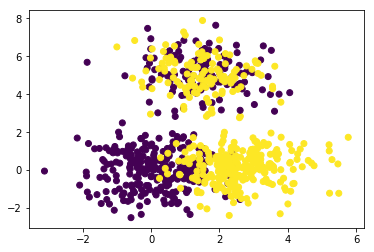

In [2]:
N = 750
mu1 = [0,0,0]
sigma1 = np.eye(3)
mu2 = [2.5,0,0]
sigma2 = np.eye(3)

mu3 = [1.5,5,0]
sigma3 = np.eye(3)

d1 = np.random.multivariate_normal(mu1, sigma1, 250)
d2 = np.random.multivariate_normal(mu2,sigma2, 250)
d3 = np.random.multivariate_normal(mu3,sigma3, 250)
d1 = d1[np.argsort(d1[:,0])]
d2 = d2[np.argsort(d2[:,0])]
idx = np.hstack((-1*np.ones(250), 1*np.ones(250), -1*np.ones(125), np.ones(125)))
d_all = np.vstack((d1,d2,d3))
plt.scatter(d_all[:,0], d_all[:,1], c=idx)
plt.show()

## build graph, get fourier basis

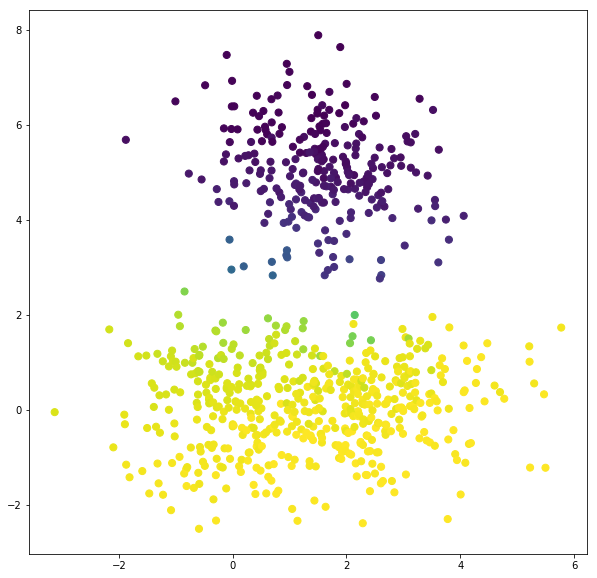

In [3]:
g = gt.Graph(d_all,decay=20, knn=5, use_pygsp = True)
g.compute_fourier_basis()
plt.figure(figsize = (10,10))

plt.scatter(d_all[:,0], d_all[:,1], c=g.U[:,1],s=50)
plt.show()

## Cluster embedding normally

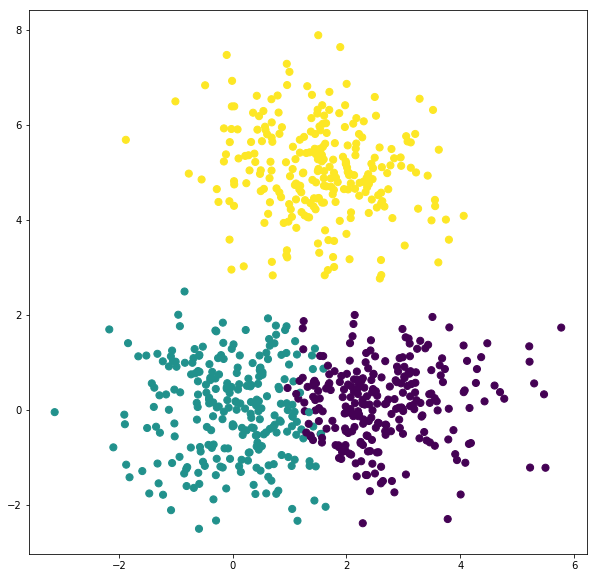

In [4]:

plt.figure(figsize = (10,10))
clabels = KMeans(n_clusters=3).fit_predict(g.U[:,0:3])
plt.scatter(d_all[:,0], d_all[:,1], c=clabels,s =50)
plt.show()

In [123]:
meldobj = mc.MELDCluster(k=4,window_count=4)

In [124]:
meldobj.fit(g,refit=True)

/media/jaystanley/ExtraDrive1/External/experiments/MELD/python/meld/meldconvex.py:307: UserWarning: sparse windows not supported.Casting to np.ndarray.
  "Call MELDCluster.fit(). ")


MELDCluster(k=4, suppress=False, window=None, window_count=4,
      window_sizes=array([1, 2, 4, 8]))

In [125]:
meldobj.transform(idx)

array([[4.92750197e-01, 3.19268377e-01, 7.87183947e-01, ...,
        5.12072168e-09, 5.12741595e-07, 2.88753867e-10],
       [4.61187370e-01, 2.86792702e-01, 7.16711012e-01, ...,
        2.52589330e-08, 2.35945043e-06, 2.16665646e-09],
       [4.51852903e-01, 3.17888718e-01, 7.34821975e-01, ...,
        1.95749094e-10, 1.13832988e-09, 3.76357749e-07],
       ...,
       [2.68858418e-01, 3.86356162e-01, 2.92784049e-03, ...,
        2.38027057e-04, 2.06245827e-03, 3.08096017e-11],
       [1.14042508e-01, 1.64472149e-01, 8.98264530e-03, ...,
        1.03443760e-01, 3.65338478e-05, 3.04112610e-08],
       [9.53596680e-02, 1.38715424e-01, 8.72590808e-03, ...,
        6.05819104e-03, 2.62896145e-05, 8.92258333e-08]])

/media/jaystanley/ExtraDrive1/External/experiments/MELD/python/meld/meldconvex.py:326: UserWarning: Overwriting previous spectrogram. Suppress this warning with MELDCluster(suppress=True)
  @k.setter


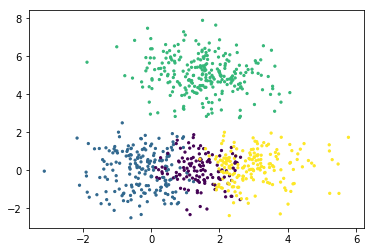

In [126]:
labels = meldobj.predict(idx)
plt.scatter(d_all[:,0], d_all[:,1], c=labels, s=5)


In [101]:
meldobj._clusterobj

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [31]:
meldobj._compute_spectrogram(idx,meldobj._U, meldobj._h[:,:,1].astype(float))

array([[ 2.53838024e-02, -1.64631736e-02,  4.16942797e-02, ...,
         7.28071469e-12,  4.29480546e-11, -6.33666512e-12],
       [ 3.04768294e-02, -1.89949947e-02,  4.85167582e-02, ...,
        -5.00887603e-11,  2.94741380e-09, -1.52285626e-11],
       [ 3.53160810e-02, -2.48462333e-02,  5.88932054e-02, ...,
         9.22880597e-12,  1.64447345e-13, -1.85774023e-08],
       ...,
       [-2.59819309e-02, -3.74779272e-02,  3.84263108e-04, ...,
         1.04313915e-05,  1.82912449e-05, -2.71985216e-12],
       [-8.38680347e-03, -1.21216437e-02,  6.80053047e-04, ...,
        -3.58462734e-03,  1.79720995e-06, -4.87560400e-10],
       [-7.58660534e-03, -1.09385352e-02,  7.28996793e-04, ...,
        -2.45884138e-04, -2.90525563e-07, -2.48181428e-10]])

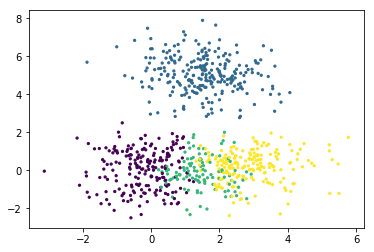

In [86]:
k=4
ts  = np.power(2,np.arange(9))
wgfts = np.zeros((g.N,len(ts)*g.N))

for i,t in enumerate(ts):
    window = np.linalg.matrix_power(g.diff_op.toarray(),t)
    window = sklp.normalize(window, 'l2', axis=0).T
    C = np.multiply(window, idx[:, None])
    C = g.gft(C)
    wgfts[:,i*g.N:(i+1)*g.N] = C.T
wgfts_reshape = np.reshape(wgfts, (g.N,g.N, len(ts)),'F')
to_clust2 = (np.sum(np.tanh(np.abs(wgfts_reshape)),axis=2))
labels2 = KMeans(n_clusters=k).fit_predict(to_clust2)
plt.scatter(d_all[:,0], d_all[:,1], c=labels2, s=5)



## Get a signal-biased spectral clustering, a spectrogram, and its saturation function

In [5]:
Cbase, labels,saturation_function = mc.spectrogram_clustering(g, idx,t = 40,nclusts = 3,saturation = 0.1) 

## Here's what our clustering looks like with a window size of t = 40 and a saturation = 0.1

## Let's look inside of what's going on with saturation:

Here's what the spectrogram (and clustering) looks like without any saturation

/media/jaystanley/ExtraDrive1/External/experiments/MELD/python/meld/meldconvex.py:193: UserWarning: Checking Laplacian fourier basis
  "Checking Laplacian fourier basis")


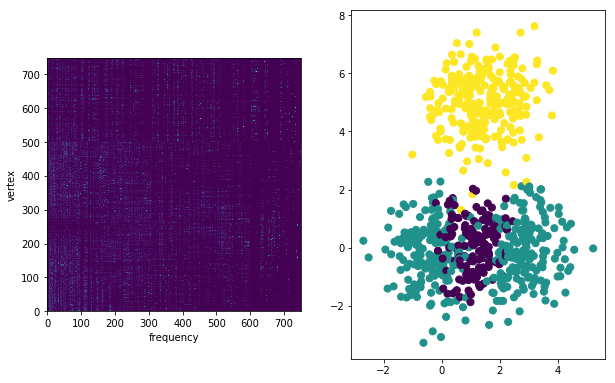

In [11]:
Cbase = mc.compute_spectrogram(g,idx,t=2)
to_clust = (np.abs(Cbase.T)) #mc.saturation_function(Cbase.T,alpha=10)
to_clust = np.tanh(0.5*to_clust)
labels = KMeans(n_clusters=3).fit_predict(to_clust)
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols =2, figsize = (10,10))
ax1.imshow(to_clust, origin = 'lower')
ax1.set_xlabel('frequency')
ax1.set_ylabel('vertex')
ax2.scatter(d_all[:,0], d_all[:,1], c=labels,s =50)
ax2.set_aspect('equal')
plt.show()

/media/jaystanley/ExtraDrive1/External/experiments/MELD/python/meld/meldconvex.py:193: UserWarning: Checking Laplacian fourier basis
  "Checking Laplacian fourier basis")


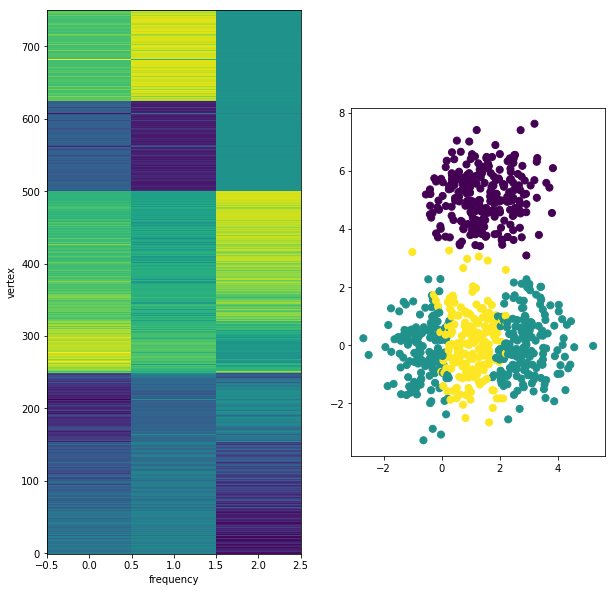

In [74]:
Cbase = mc.compute_spectrogram(g,idx,t=1)
k = 3
to_clust = (Cbase.T[:,:k])/np.linalg.norm(Cbase.T[:,:k], axis=1)[:,np.newaxis]#mc.saturation_function(Cbase.T,alpha=10)
to_clust = (to_clust*(g.U[:,:k]/np.linalg.norm(g.U[:,:k],axis=1)[:,np.newaxis]))
labels = KMeans(n_clusters=k).fit_predict(np.abs(to_clust))
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols =2, figsize = (10,10))
ax1.imshow(to_clust, origin = 'lower',aspect='auto')
ax1.set_xlabel('frequency')
ax1.set_ylabel('vertex')
ax2.scatter(d_all[:,0], d_all[:,1], c=labels,s =50)
ax2.set_aspect('equal')
plt.show()

In [92]:
h = gsp.filters.Heat(g, 100)

In [93]:
window = sklp.normalize(h.filter(np.eye(g.N)),'l2',axis=0).T

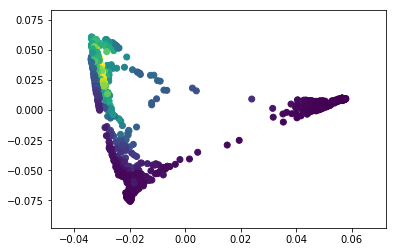

In [95]:
plt.scatter(g.U[:,1],g.U[:,2],c=window[:,100])

In [290]:
u,s,v = np.linalg.svd(mc.saturation_function(Cbase.T,alpha=1))

/media/jaystanley/ExtraDrive1/External/experiments/MELD/python/meld/meldconvex.py:166: UserWarning: No f or invalid f supplied. Using f=tanh(alpha*np.abs(x)) for saturation.
  "No f or invalid f supplied. "


In [270]:
s.shape

(750,)

/media/jaystanley/ExtraDrive1/External/experiments/MELD/python/meld/meldconvex.py:166: UserWarning: No f or invalid f supplied. Using f=tanh(alpha*np.abs(x)) for saturation.
  "No f or invalid f supplied. "


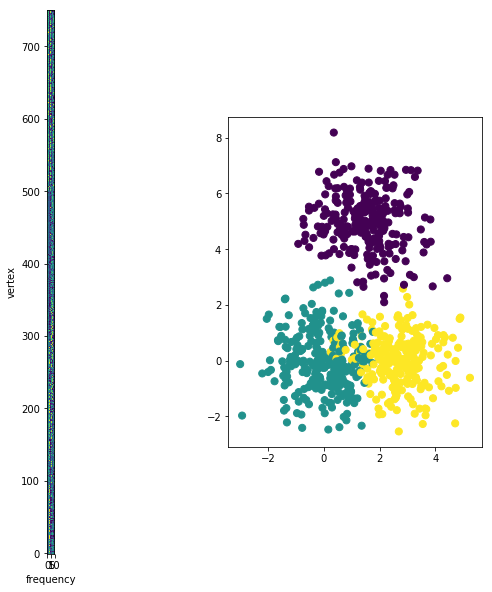

In [304]:

labels = KMeans(n_clusters=3).fit_predict((u@np.diag(s)))
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols =2, figsize = (10,10))
ax1.imshow(mc.saturation_function(Cbase.T[:,:10]/np.linalg.norm(Cbase.T[:,:10],axis=1)[:,np.newaxis],alpha=1), origin = 'lower')
ax1.set_xlabel('frequency')
ax1.set_ylabel('vertex')
ax2.scatter(d_all[:,0], d_all[:,1], c=labels,s =50)
ax2.set_aspect('equal')
plt.show()

### Let's look at the matrix with the saturation function applied. This is what the clustering is done on.
### Saturation = 0.1

NameError: name 'C' is not defined

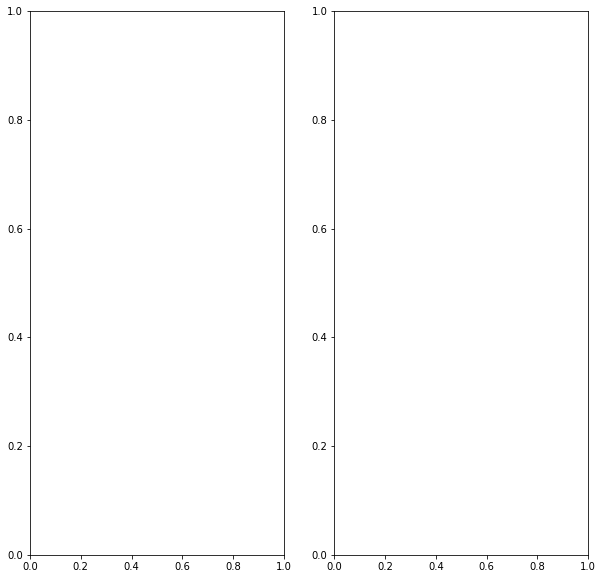

In [7]:
sat = 0.1
labels = KMeans(n_clusters=3).fit_predict(saturation_function(Cbase,sat))
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols =2, figsize = (10,10))
ax1.imshow(saturation_function(C,sat), origin = 'lower')
ax1.set_xlabel('frequency')
ax1.set_ylabel('vertex')
ax2.scatter(d_all[:,0], d_all[:,1], c=labels,s =50)
ax2.set_aspect('equal')
plt.show()

### Saturation = 0.5

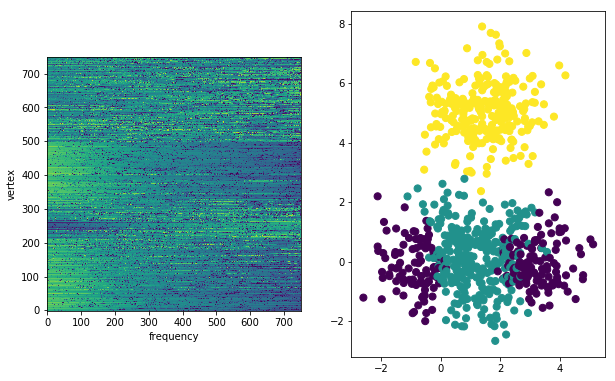

In [46]:
sat = 0.5
labels = KMeans(n_clusters=3).fit_predict(saturation_function(Cbase,sat))
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols =2, figsize = (10,10))
ax1.imshow(saturation_function(C,sat), origin = 'lower')
ax1.set_xlabel('frequency')
ax1.set_ylabel('vertex')
ax2.scatter(d_all[:,0], d_all[:,1], c=labels,s =50)
ax2.set_aspect('equal')
plt.show()

### Saturation = 0.9 (you can go much higher)

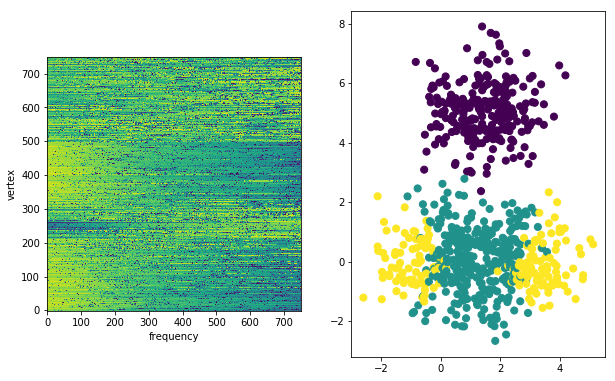

In [45]:
sat = 0.9
labels = KMeans(n_clusters=3).fit_predict(saturation_function(Cbase,sat))
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols =2, figsize = (10,10))
ax1.imshow(saturation_function(C,sat), origin = 'lower')
ax1.set_xlabel('frequency')
ax1.set_ylabel('vertex')
ax2.scatter(d_all[:,0], d_all[:,1], c=labels,s =50)
ax2.set_aspect('equal')
plt.show()

### Now let's look at the effect of t on our clustering and the underlying histogram

### t =1 

In [8]:
sat = 0.1
t = 1
C, labels, _ = mc.spectrogram_clustering(g, idx,t = t,nclusts = 3,saturation =sat) 


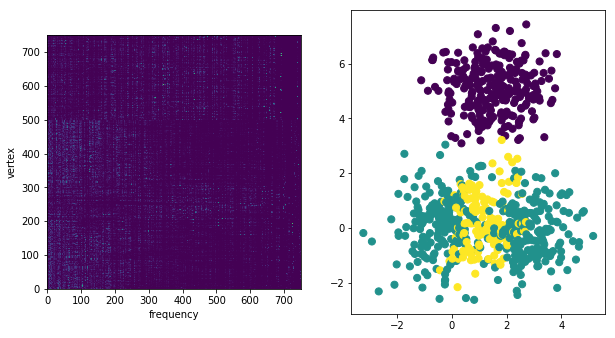

In [10]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols =2, figsize = (10,10))
ax1.imshow(saturation_function(C,0.1), origin = 'lower')
ax1.set_xlabel('frequency')
ax1.set_ylabel('vertex')
ax2.scatter(d_all[:,0], d_all[:,1], c=labels,s =50)
ax2.set_aspect('equal')
plt.show()

### t = 10

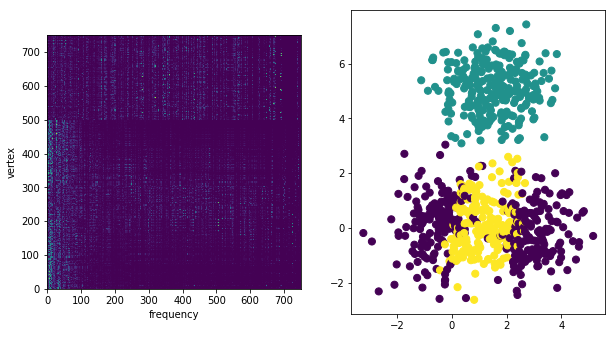

In [11]:
sat = 0.1
t = 10
C, labels, _ = mc.spectrogram_clustering(g, idx,t = t,nclusts = 3,saturation =sat) 
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols =2, figsize = (10,10))
ax1.imshow(saturation_function(C,0.1), origin = 'lower')
ax1.set_xlabel('frequency')
ax1.set_ylabel('vertex')
ax2.scatter(d_all[:,0], d_all[:,1], c=labels,s =50)
ax2.set_aspect('equal')
plt.show()

### t = 20

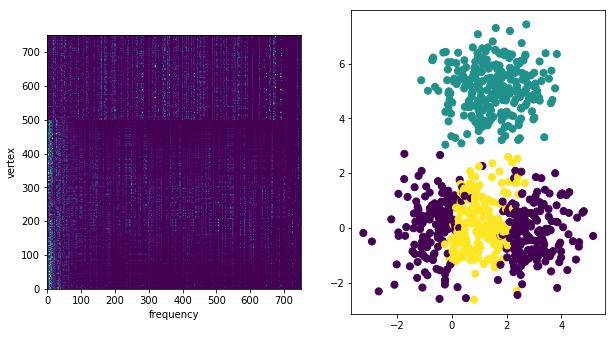

In [12]:
sat = 0.1
t = 20
C, labels, _ = mc.spectrogram_clustering(g, idx,t = t,nclusts = 3,saturation =sat) 
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols =2, figsize = (10,10))
ax1.imshow(saturation_function(C,0.1), origin = 'lower')
ax1.set_xlabel('frequency')
ax1.set_ylabel('vertex')
ax2.scatter(d_all[:,0], d_all[:,1], c=labels,s =50)
ax2.set_aspect('equal')
plt.show()

### t = 40

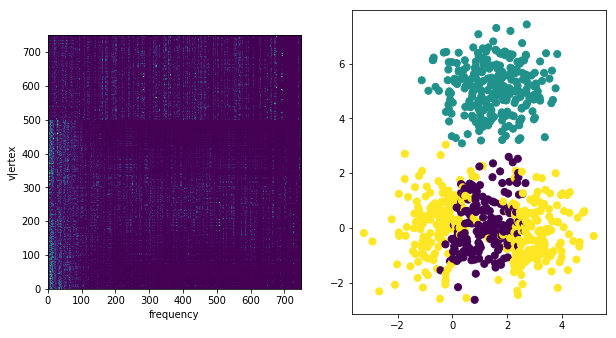

In [13]:
sat = 0.1
t = 10
C, labels, _ = mc.spectrogram_clustering(g, idx,t = t,nclusts = 3,saturation =sat) 
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols =2, figsize = (10,10))
ax1.imshow(saturation_function(C,0.1), origin = 'lower')
ax1.set_xlabel('frequency')
ax1.set_ylabel('v|ertex')
ax2.scatter(d_all[:,0], d_all[:,1], c=labels,s =50)
ax2.set_aspect('equal')
plt.show()

### t=80

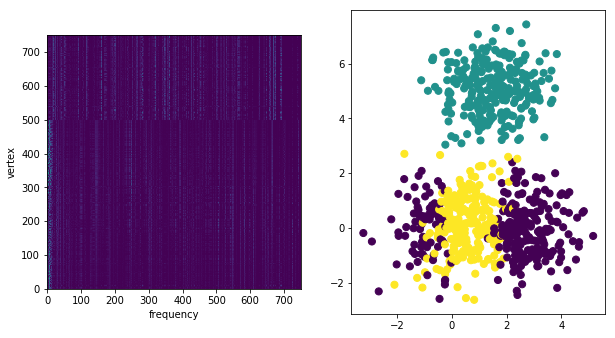

In [14]:
import graphtools
import graphtools.base
import scipy.sparse as sparse
import inspect
from sklearn.base import BaseEstimator
from sklearn.cluster import KMeans
from . import utils
from sklearn import preprocessing
from scipy.linalg import expm
from scipy.linalg import fractional_matrix_power as fmp
import sklearn.preprocessing as sklp
import warnings
from functools import partial


def _check_pygsp_graph(G):
    if isinstance(G, graphtools.base.BaseGraph):
        if not isinstance(G, pygsp.graphs.Graph):
            raise TypeError(
                "Input graph should be of type pygsp.graphs.Graph. "
                "With graphtools, use the `use_pygsp=True` flag.")
    else:
        raise TypeError(
            "Input graph should be of graphtools.base.BaseGraph."
            "With graphtools, use the `use_pygsp=True` flag.")


def meld(X, G, beta, offset=0, order=1, solver='chebyshev', M=50,
         lap_type='combinatorial', fi='regularizedlaplacian', alpha=2):
    """
    Performs convex meld on the input signal.
    This function solves:

        (1) :math:`sol = argmin_{z} \frac{1}{2}\|x - z\|_2^2 + \beta \| \nabla x\|_2^2`

        OR
        regularizes (1) using \inner{X, randomwalk(L)*X}, the p-step random walk (math to come)

    Note the nice following relationship for (1):

        (2) :math:`x^T L x = \| \nabla x\|_2^2`

    Also note that the solution to (1) may be phrased as the lowpass filter:

        (3) :math:`sol = h(L)x` with :math:`h(\lambda) := \frac{1}{1+\beta\lambda}`

    We use (3) by default as it is faster in the case of few input signals.


    Parameters
    ----------
    X : ndarray [n, p]
        2 dimensional input signal array to meld.
    G : graphtools.Graph object
        Graph to perform data smoothing over.
    beta : int
        Amount of smoothing to apply.
        Acts as 'p' parameter if fi == 'randomwalk'
    offset: int, optional, Default: 0
        Amount to shift the MELD filter in the eigenvalue spectrum.
        Recommend using an eigenvalue from g based on the
        spectral distribution.
    order: int, optional, Default: 1
        Falloff and smoothness of the filter.
        High order leads to square-like filters.
    Solver : string, optional, Default: 'chebyshev'
        Method to solve convex problem.
        'cheby' uses a chebyshev polynomial approximation of the corresponding filter
        'exact' uses the eigenvalue solution to the problem
        'matrix' is deprecated and may not function appropriately
    M : int, optional, Default: 50
        Order of chebyshev approximation to use.
    fi: string, optional, Default: 'regularizedlaplacian'
        Filter to use for (1).
        'regularizedlaplacian' is the exact solution of (1)
        'randomwalk' is a randomwalk polynomial that is related to diffusion via rw = ((alpha-1)I+P)^t

    Returns
    -------
    sol : ndarray [n, p]
        2 dimensional array of smoothed input signals
    """

    if not isinstance(solver, str):
        raise TypeError("Input method should be a string")
    solver = solver.lower()

    if not isinstance(fi, str):
        raise TypeError("Input filter should be a string")
    fi = fi.lower()
    if fi not in ['regularizedlaplacian', 'randomwalk']:
        raise NotImplementedError(
            '{} filter is not currently implemented.'.format(fi))

    _check_pygsp_graph(G)

    if not isinstance(lap_type, str):
        raise TypeError("Input lap_type should be a string")
    lap_type = lap_type.lower()
    Gbak = G
    if G.lap_type != lap_type:
        warnings.warn(
            "Changing lap_type may require recomputing the Laplacian")
        G.compute_laplacian(lap_type)

    if X.shape[0] != G.N:
        if len(X.shape) > 1 and X.shape[1] == G.N:
            print(
                "input matrix is column-wise rather than row-wise. "
                "transposing (output will be transposed)")
            X = X.T
        else:
            raise ValueError(
                "Input data ({}) and input graph ({}) "
                "are not of the same size".format(X.shape, G.N))

    if fi == 'randomwalk':
        # used for random walk stochasticity
        D = sparse.diags(np.ravel(np.power(G.W.sum(0), -1)), 0).tocsc()
    if solver == 'matrix':
        # use matrix inversion / powering
        I = sparse.identity(G.N)
        if fi == 'regularizedlaplacian':  # fTLf
            mat = sparse.linalg.inv(
                (I + np.matrix_power(beta * G.L - offset * I, order)).tocsc())
        elif fi == 'randomwalk':  # p-step random walk
            mat = (alpha * I - (G.L * D))**beta

        sol = mat.T @ X  # apply the matrix
        sol = np.squeeze(np.asarray(sol))  # deliver a vector

    else:
        # use approximations
        if fi == 'regularizedlaplacian':  # fTLf
            def filterfunc(x): return 1 / (1 + (beta * x - offset)**order)

        elif fi == 'randomwalk':  # p-step random walk
            L_bak = G.L
            # change the eigenbasis by normalizing by degree (stochasticity)
            G.L = (L_bak * D).T

            def filterfunc(x): return (alpha - x)**beta

        G.estimate_lmax()
        filt = pygsp.filters.Filter(G, filterfunc)  # build filter
        sol = filt.filter(X, method=solver, order=M)  # apply filter
        if fi == 'randomwalk':
            G.L = L_bak  # restore L

    sol = utils.convert_to_same_format(sol, X)

    Gout = G
    G = Gbak

    return sol, Gout


class MELDCluster(BaseEstimator):

    def __init__(self, k=10, window_count=9, window_sizes=None, window=None,
                 activation_fn=None, store_Cs=False, activated=True,
                 suppress=False, **kwargs):

        self.suppress = suppress
        if window is not None:
            raise NotImplementedError(
                "User defined windows have not been implemented.")
        else:
            self._basewindow = None
        if not callable(activation_fn):
            if activation_fn is not None:
                if not self.suppress:
                    warnings.warn(
                        "Invalid activaiton_fn supplied. "
                        "Using f=tanh(alpha*np.abs(x)) for saturation.")

            def _activate(self, x, alpha=1):
                return np.tanh(alpha * np.abs(x))
        else:
            def _activate(self, x, **kwargs):
                return activation_fn(x, **kwargs)
        if window_sizes is None:
            self.window_sizes = np.power(2, np.arange(window_count))
        else:
            self.window_sizes = window_sizes
        if not self.suppress:
            if not activated and not store_Cs:
                warnings.warn(
                    "store_Cs = False implies that spectrograms will "
                    "be summed. If activated = False, the "
                    "master spectrogram will be incorrect.")

        self.window_count = np.min(self.window_sizes.shape)
        self._activated = activated
        self._k = k
        self._store_Cs = store_Cs
        self._h = None
        self._U = None
        self._N = None
        self._Cs = None
        self._C = None
        self._isfit = False
        self.__sklearn_params = kwargs

        self.__clusterobj = KMeans(self._k, self.__sklearn_params)

    def _compute_spectrogram(self, s, U, window):

        if sparse.issparse(window):
            if not isinstance(window, sparse.csr_matrix):
                if not self.suppress:
                    warnings.warn("window must be a numpy.array or "
                                  "scipy.sparse.csr_matrix."
                                  " Casting to csr_matrix")
                window = sparse.csr(window)
        else:
            if not isinstance(window, np.array):
                raise TypeError(
                    "window must be a numpy.array or"
                    "scipy.sparse.csr_matrix.")
        C = np.multiply(window, s[:, None])
        U = np.conjugate(U)
        return np.tensordot(U, C, ([0], [0])).T

    def _compute_window(self, window, **kwargs):
        if sparse.issparse(window):
            if not isinstance(window, sparse.csr_matrix):
                if not self.suppress:
                    warnings.warn("window must be a numpy.array or "
                                  "scipy.sparse.csr_matrix."
                                  " Casting to csr_matrix")
                window = sparse.csr(window)
            else:
                return window**kwargs['t']
        else:
            if not isinstance(window, np.array):
                raise TypeError(
                    "window must be a numpy.array or"
                    "scipy.sparse.csr_matrix.")
            else:
                return np.linalg.matrix_power(window, kwargs['t'])

    def fit(self, G, refit=False):
        _check_pygsp_graph(G)
        if self._isfit and not refit:
            warnings.warn("Estimator is already fit. "
                          "Call MELDCluster.fit(G,refit=True)"
                          " to refit")
            return self
        if self._basewindow is None:
            self._basewindow = G.diff_op
        self._h = np.zeros((G.N, G.N, self.window_count)
                           ).astype(type(self._basewindow))

        for i, t in enumerate(self.window_sizes):
            self._h[:, :, i] = self._compute_window(self._basewindow, t=t)
        self._U = G.U
        self._N = G.N
        self._isfit = True
        return self

    def transform(self, s, center=True):
        if not self.suppress:
            if (self._C is not None or self._Cs is not None):
                warnings.warn("Overwriting previous spectrogram. "
                              "Suppress this warning with "
                              "MELDCluster(suppress=True)")
        if not self._isfit:
            if not self.suppress:
                warnings.warn("Estimator is not fit. "
                              "Call MELDCluster.fit(). ")
            return None
        else:
            if not isinstance(s, (list, tuple, np.ndarray)):
                raise TypeError('Input signal s must be ')
            s = np.array(s)
            if self._N not in s.shape:
                raise ValueError('At least one axis of s must be'
                                 ' of length N.')
            else:
                if s.ndim > 1:
                    if s.shape[1] == self._N and s.shape[0] != self._N:
                        s = s.T
                    ncols = s.shape[1]
                else:
                    ncols = 1
                    s = s[:, np.newaxis]
                if center:
                    s = s - np.mean(s, axis=0)
                self._C = np.zeros((self._N, self._N, ncols))
                if self._store_Cs:
                    self._Cs = np.zeros((
                        self._N, self._N, self.window_count, ncols))
                for i in range(ncols):
                    for t in range(self.window_count):
                        temp = self._compute_spectrogram(
                            s[:, i], self._U, self.self._h[:, :, t])
                        if self._activated:
                            temp = self._activate(
                                temp)
                        if self._store_Cs:
                            self._Cs[:, :, t, i] = temp
                        else:
                            self._C[:, :, i] += temp

        return self._C

    def fit_transform(self, G, s, **kwargs):
        self.fit(G, **kwargs)
        return self.transform(s, kwargs)

    def predict(self, s=None, **kwargs):
        if not self._isfit:
            warnings.warn("Estimator is not fit. "
                          "Call MELDCluster.fit(). ")
            return None
        if self._C is None and s is None:
            warnings.warn("Estimator has no spectrogram to cluster. "
                          "Call MELDCluster.transform(s). ")
            return None
        elif s is not None and self._C is not None:
            self.transform(s, kwargs)

        return self.__clusterobj.fit_predict(self._C)

    def fit_predict(self, G, s, **kwargs):
        self.fit_transform(G, s, kwargs)
        return self.predict(s)

    @property
    def k(self):
        return self._k

    @k.setter
    def k(self, newk):
        self._k = newk
        self.__clusterobj.set_params(k=self._k)

    def set_kmeans_params(self, **kwargs):
        k = kwargs.pop('k', False)
        if k:
            self._k = k
        self.__sklearn_params = kwargs
        self.__clusterobj.set_params(self.__sklearn_params, k=self._k)


def compute_spectrogram(G, s, t, **kwargs):

    if G.lap_type == 'normalized':
        # convert things to the combinatorial laplacian
        warnings.warn(
            "Converting to combinatorial Laplacian.")
        G.compute_laplacian('combinatorial')
        '''we have to make this check because
        compute_laplacian does not clean up the fourier basis'''
        warnings.warn(
            "Recomputing Laplacian fourier basis for combinatorial")
        G.compute_fourier_basis(recompute=True)
    else:
        G.compute_fourier_basis()
    C = np.zeros((G.N, G.N))

    window = np.linalg.matrix_power(G.diff_op, t)


def spectrogram_clustering_deprecated(G, s=None, t=1, saturation=0.5, explicit_compute=False,
                                      lap_type='combinatorial', matrix_compute=False, kernel=None, clusterobj=None,
                                      n_clusters=5, run_clusters=True, precomputed_nwgft=None, **kwargs):
    """spectrogram_clustering

    Parameters
    ----------
    G : TYPE
        Description
    s : None, optional
        Description
    t : int, optional
        Description
    saturation : float, optional
        Description
    explicit_compute : bool, optional, default = False
        Use the translation/modulation operation algorithmically (with for loops) described by Shuman et al. 
    lap_type : str, optional, default = 'normalized'
        Laplacian to use.  Options are 'normalized' and 'combinatorial'
        Note that you will need to use a different t scale for normalized vs combinatorial.  
    matrix_compute : bool, optional, default = True
        Use Chebyshev filters(False) or matrices(True) to compute windows. 
        Used when explicit_compute is false. This will affect your t scale.  
    kernel : None, optional
        Description
    clusterobj : None, optional
        Description
    n_clusters : int, optional
        Description
    run_clusters : bool, optional, default = True
        Run clustering algorithm
    precomputed_nwgft : np.ndarray, optional, default = None
        Precomputed spectrogram.  Equivalent to clustering with saturation.
    **kwargs
        Description

    Returns
    -------
    TYPE
        Description

    Raises
    ------
    RuntimeError
        Description
    TypeError
        Description
    """

    def saturation_func(x, alpha): return np.tanh(
        alpha * np.abs(x.T))  # TODO: extend to allow different saturation functions

    if not(isinstance(clusterobj, KMeans)):
        # todo: add support for other clustering algorithms
        if clusterobj is None:
            clusterobj = KMeans(n_clusters=n_clusters, **kwargs)
        else:
            raise TypeError(
                "Currently only sklearn.cluster.KMeans is supported for "
                "clustering object. Got {}".format(type(clusterobj)))

    if precomputed_nwgft is not None:
        # we don't need to do much if we have a precomputed nwgft
        C = precomputed_nwgft
    else:
        # check that signal and graph are defined
        if s is None:
            raise RuntimeError(
                "If no precomputed_nwgft, then a signal s should be supplied.")
        _check_pygsp_graph(G)
        # build kernel
        if not isinstance(lap_type, str):
            raise TypeError("Input lap_type should be a string")
        lap_type = lap_type.lower()
        Gbak = G
        if G.lap_type != lap_type:
            warnings.warn(
                "Changing lap_type may require recomputing the Laplacian")
            G.compute_laplacian(lap_type)

        # OK now we are going to compute some windows
        if explicit_compute:  # In this case, we actually compute the
            # kernel function over eigenvectors and then modulate/translate around as necessary
            if kernel and not(inspect.isfunction(kernel)):
                raise TypeError(
                    "Input kernel should be a lambda function (accepting "
                    "eigenvalues of the graph laplacian) or none. "
                    "Got {}".format(type(kernel)))
            if kernel is None:
                # definition of the heat kernel
                def kernel(x): return np.exp((-t * x) / G.lmax)

            ke = kernel(G.e)  # eval kernel over eigenvalues of G
            # vertex domain translation of the kernel.
            ktrans = np.sqrt(G.N) * (G.U @ np.multiply(ke[:, None], G.U.T))

            C = np.empty((G.N, G.N))

            for i in range(0, G.N):  # build frame matrix
                # copy one translate Ntimes
                kmod = np.matlib.repmat(ktrans[:, i], 1, G.N)
                kmod = np.reshape(kmod, (G.N, G.N)).T
                # modulate the copy at each frequency of G
                kmod = (G.U / G.U[:, 0]) * kmod
                kmod = kmod / np.linalg.norm(kmod, axis=0)  # normalize it
                C[:, i] = kmod.T@s  # compute nwgft frame

        else:  # in this case we are going to try to approximate things as quick as possible.
            # The easiest approximation is going to be the symmetric normalized one.
            # We have two options.  I'm not sure which one is best. The matrix is convenient.
            if matrix_compute:
                if lap_type == 'normalized':  # We can do this with the diffop
                    window = preprocessing.normalize(
                        fmp(G.diff_op.toarray(), t), 'l2', axis=0).T
                else:
                    # assume the combinatorial laplacian.
                    window = preprocessing.normalize(
                        expm(-t * G.L.toarray()), 'l2', axis=0).T
            else:  # use the chebyshev filters
                # Mind your t here.
                h = pygsp.filters.Heat(G, tau=t)
                window = preprocessing.normalize(
                    h.filter(np.eye(G.N), order=50), 'l2', axis=0).T

            C = np.multiply(window, s[:, None])
            C = G.gft(C)
    if run_clusters:
        labels = clusterobj.fit_predict(saturation_func(C, saturation))
    else:
        labels = None

    # im not clear on how my changing the laplacian around affects our original G.
    Gout = G
    G = Gbak

    return C, labels, saturation_func, clusterobj, Gout
sat = 0.1
t = 80
C, labels, _ = mc.spectrogram_clustering(g, idx,t = t,nclusts = 3,saturation =sat) 
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols =2, figsize = (10,10))
ax1.imshow(saturation_function(C,0.1), origin = 'lower')
ax1.set_xlabel('frequency')
ax1.set_ylabel('vertex')
ax2.scatter(d_all[:,0], d_all[:,1], c=labels,s =50)
ax2.set_aspect('equal')
plt.show()

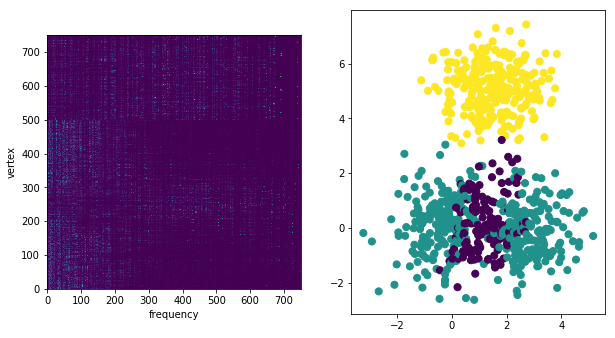

In [20]:
g = gt.Graph(d_all,decay=20, knn=5, use_pygsp = True, lap_type='normalized')


In [29]:
normdw = 1/np.sqrt(g.dw)

In [30]:
A = np.diag(normdw)@g.W@np.diag(normdw)

In [34]:
e,psi = np.linalg.eigh(A)

In [39]:
beta = np.max(1-np.abs(e))

In [220]:
max_j = 1 + (np.log2(-1/np.log2(beta)))
max_j = np.floor(max_j).astype(int)

In [44]:
T = 0.5*(np.eye(g.N)+A)

In [177]:
from scipy.linalg import fractional_matrix_power as fmp

In [203]:
wavelets = np.zeros((g.N,g.N*max_j))
for i in range(max_j):
    wavelets[:,(i*g.N):((i+1)*g.N)] = (np.linalg.matrix_power(T,int(2**(i-1))) - np.linalg.matrix_power(T,int(2**i)))

In [317]:
scattering_scales = 4
scattering = np.zeros((g.N,max_j,scattering_scales))
scattering[:,:,0] = np.reshape(wavelets.T@idx, (g.N,11),'F')
pointwise_activation = np.abs(scattering[:,:,0])
scattering2 = wavelets.T@pointwise_activation
scattering2 = np.reshape(scattering2, (g.N, 11*11),'F')
scattcoeffs1 = v.T@pointwise_activation
scattering2active = np.abs(scattering2)
scattcoeffs2 = v.T@scattering2active
scattering3 = wavelets.T@scattering2active
scattering3 = np.reshape(scattering3, (g.N, 11**3),'F')
scattering3active = np.abs(scattering3)
scattcoeffs3 = v.T@scattering3active
scattering4 = wavelets.T@scattering3active
scattering4 = np.reshape(scattering4, (g.N, 11**4),'F')
allcoeffs = np.hstack((scattering[:,:,0],scattering2,scattering3,scattering4))

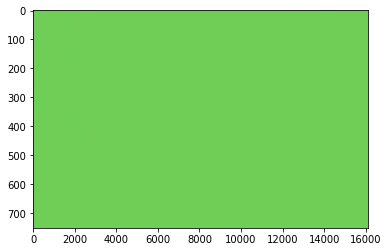

In [324]:
plt.imshow(np.tanh(1+allcoeffs/np.linalg.norm(allcoeffs,axis=1)[:,np.newaxis]),aspect='auto')

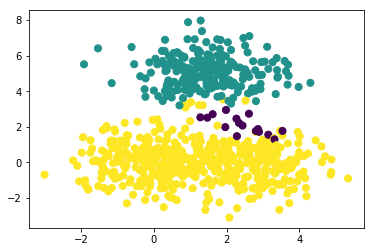

In [321]:
labels = KMeans(n_clusters=3).fit_predict(np.tanh(1+10*np.abs(allcoeffs)/np.linalg.norm(np.abs(allcoeffs),axis=1)[:,np.newaxis]))
plt.scatter(d_all[:,0], d_all[:,1], c=labels,s =50)

In [284]:
scattcoeffs2.shape

(121,)

In [260]:
scattcoeffs3 = v.T@np.abs(scattering3)


In [201]:
wavelets[:,(i*g.N):(i+1*g.N)].shape

(750, 4)

In [218]:
(wavelets.T@scattering[:,:,0]).shape

(750, 11)

In [26]:
idx[:,np.newaxis].shape

(750, 1)